# Kmeans motifs

## Kmeans

### Data

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
from katlas.core import *
import pandas as pd, numpy as np,seaborn as sns

In [ ]:
# human = pd.read_parquet('raw/human_phosphoproteome.parquet')
# df_grouped = pd.read_parquet('raw/combine_source_grouped.parquet')
human = Data.get_human_site()
df_grouped = Data.get_ks_dataset()

In [ ]:
all_site = pd.concat([human,df_grouped])

In [ ]:
all_site.sub_site.isna().sum()

np.int64(0)

In [ ]:
all_site = all_site.drop_duplicates('sub_site')

In [ ]:
all_site.shape

(131843, 21)

In [ ]:
# all_site = all_site[['sub_site','site_seq']].drop_duplicates('sub_site')

## One-hot encode

In [ ]:
%%time
onehot = onehot_encode(all_site['site_seq'])

CPU times: user 2.21 s, sys: 1.14 s, total: 3.35 s
Wall time: 3.35 s


In [ ]:
onehot.head()

-20A  -20C  -20D  -20E  -20F  -20G  -20H  -20I  -20K  -20L  ...  20R  20S  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  1.0  0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   
2   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   
3   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   

   20T  20V  20W  20Y  20_  20s  20t  20y  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 967 columns]

### Elbow method

In [ ]:
all_site.shape

(131843, 19)

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

CPU times: user 23min 20s, sys: 46.3 s, total: 24min 6s
Wall time: 9min 50s


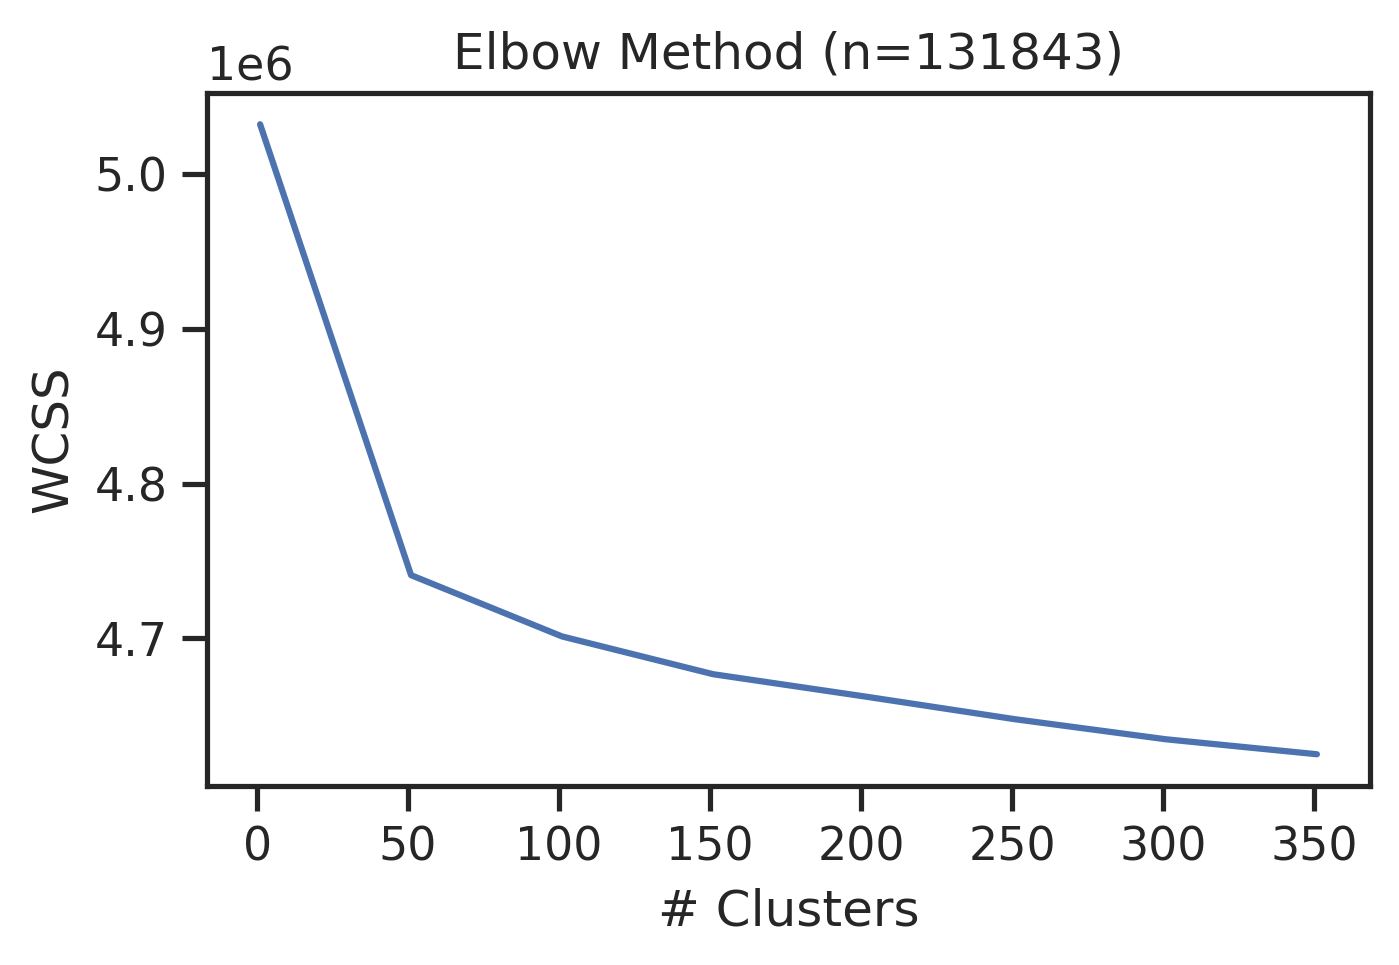

In [ ]:
%%time
get_clusters_elbow(onehot)

### Kmeans

If using RAPIDS

In [ ]:
# # pip install --extra-index-url=https://pypi.nvidia.com \"cudf-cu12==25.2.*\" \"cuml-cu12==25.2.*\"

# %load_ext cudf.pandas

# import numpy as np, pandas as pd
# from cuml import KMeans
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
# from katlas.core import *
# from katlas.plot import *

In [ ]:
def kmeans(onehot,n=2,seed=42):
    kmeans = KMeans(n_clusters=n, random_state=seed,n_init='auto')
    return kmeans.fit_predict(onehot)

In [ ]:
ncluster=[50,150,300]
seeds=[42,2025,28]

In [ ]:
all_site['test_id']=1

In [ ]:
get_cluster_pssms(all_site,'test_id')

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


-20P     -20G     -20A     -20C     -20S     -20T    -20V    -20I  \
1  0.07984  0.06669  0.07291  0.01333  0.06488  0.04065  0.0505  0.0346   

     -20L     -20M  ...      20H      20K      20R      20Q     20N      20D  \
1  0.0812  0.01958  ...  0.02192  0.06782  0.06339  0.04731  0.0334  0.05239   

      20E     20pS     20pT     20pY  
1  0.0798  0.04184  0.01385  0.00508  

[1 rows x 943 columns]

In [ ]:
pssms=[]
for seed in seeds:
    print('seed',seed)
    for n in ncluster:
        colname = f'cluster{n}_seed{seed}'
        print(colname)
        all_site[colname] = kmeans(onehot,n=n,seed=seed)
        pssm_df = get_cluster_pssms(all_site,colname) # count threshold 10, no threshold for non-nan
        pssm_df.index =colname+'_'+pssm_df.index.astype(str)
        pssms.append(pssm_df)

seed 42
cluster50_seed42


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.46it/s]


cluster150_seed42


100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 34.35it/s]


cluster300_seed42


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 45.00it/s]


seed 2025
cluster50_seed2025


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.37it/s]


cluster150_seed2025


100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 34.96it/s]


cluster300_seed2025


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:07<00:00, 42.13it/s]


seed 28
cluster50_seed28


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.92it/s]


cluster150_seed28


100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 33.37it/s]


cluster300_seed28


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:07<00:00, 41.01it/s]


In [ ]:
pssms = pd.concat(pssms,axis=0)

Save:

In [ ]:
# pssms.to_parquet('raw/kmeans.parquet')
# all_site.to_parquet('raw/kmeans_site.parquet',index=False)

In [ ]:
# pssms = pd.read_parquet('raw/kmeans.parquet')

# all_site=pd.read_parquet('raw/kmeans_site.parquet')

## Hierarchical clustering

### Hierarchical clustering of all pssms

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram

In [ ]:
import pandas as pd
from katlas.core import *

In [ ]:
pssms = pd.read_parquet('raw/kmeans.parquet')

In [ ]:
labels= get_pssm_seq_labels(pssms)

In [ ]:
Z = get_Z(pssms)

  0%|          | 0/1124250 [00:00<?, ?it/s]

In [ ]:
plot_dendrogram(Z,labels=labels)
save_pdf('dendrogram.pdf')
plt.close()

Visualize and find out the color threshold that works. 

After determine the color threshold, use it to cut the tree.

Visualize some logos

In [ ]:
plot_logos(pssms, 'cluster300_seed28_217','cluster50_seed42_40')

### Cut trees to merge similar pssms

In [ ]:
labels = fcluster(Z, t=0.03, criterion='distance')
# pssm_df['cluster'] = labels

In [ ]:
len(labels)

1500

In [ ]:
np.unique(labels)[:10] # always start from 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

###  Expand the cluster into a single column

In [ ]:
id_vars = ['sub_site', 'site_seq']
value_vars = [col for col in all_site.columns if col.startswith('cluster')]

In [ ]:
all_site_long = pd.melt(all_site, id_vars=id_vars, value_vars=value_vars, var_name='cluster_info', value_name='cluster')

In [ ]:
all_site_long['cluster_id']=all_site_long['cluster_info'] + '_' + all_site_long['cluster'].astype(str)

In [ ]:
all_site_long.head()

sub_site                                   site_seq  \
0  A0A024R4G9_S20  _MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTR   
1  A0A075B6Q4_S24  QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPG   
2  A0A075B6Q4_S35  EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKTHRAIADHLF   
3  A0A075B6Q4_S57  EDCMSVPGKTHRAIADHLFWsEETKSRFTEYsMTssVMRRN   
4  A0A075B6Q4_S68  RAIADHLFWsEETKSRFTEYsMTssVMRRNEQLTLHDERFE   

       cluster_info  cluster           cluster_id  
0  cluster50_seed42       33  cluster50_seed42_33  
1  cluster50_seed42       41  cluster50_seed42_41  
2  cluster50_seed42       30  cluster50_seed42_30  
3  cluster50_seed42       30  cluster50_seed42_30  
4  cluster50_seed42       11  cluster50_seed42_11

In [ ]:
# all_site_long.to_parquet('raw/kmeans_site_long.parquet',index=False)

### Map merged cluster

In [ ]:
len(labels)

1500

In [ ]:
cluster_map = pd.Series(labels,index=pssms.index)

In [ ]:
cluster_map.sort_values()

cluster50_seed42_28          1
cluster300_seed42_272        1
cluster150_seed2025_137      1
cluster150_seed28_104        1
cluster150_seed42_147        1
                          ... 
cluster150_seed2025_134    783
cluster50_seed2025_8       783
cluster150_seed42_101      783
cluster50_seed28_48        783
cluster150_seed28_131      783
Length: 1500, dtype: int32

For those unmapped cluster_ID, we assign them zero value:

In [ ]:
# not all cluster_id have a corresponding for new cluster ID, as they could be filtered out
all_site_long['cluster_new'] = all_site_long.cluster_id.map(lambda x: cluster_map.get(x, 0)) #0 is unmapped

In [ ]:
# all_site_long.to_parquet('raw/kmeans_site_long_cluster_new.parquet',index=False)

### Get new cluster motifs

In [ ]:
pssms2 = get_cluster_pssms(all_site_long,
                           'cluster_new')

100%|██████████████████████████████████████████████████████████████████████████████| 783/783 [00:22<00:00, 35.32it/s]


In [ ]:
pssms2.shape

(783, 943)

In [ ]:
# pssms2 = pssms2.drop(index=0) # as 0 represents unmapped

In [ ]:
# pssms2.sort_index().to_parquet('out/all_site_pssms.parquet')

In [ ]:
pssms2 =pd.read_parquet('out/all_site_pssms.parquet')

## Hierarchical clustering of merged pssms

In [ ]:
Z = get_Z(pssms2)

In [ ]:
all_site_long.cluster_new

0          391
1          548
2          495
3          495
4          594
          ... 
1186582    689
1186583    348
1186584    672
1186585    672
1186586    701
Name: cluster_new, Length: 1186587, dtype: int32

In [ ]:
count_map = all_site_long.drop_duplicates(subset=["cluster_new","sub_site"])["cluster_new"].value_counts()

In [ ]:
count_map

cluster_new
741    12595
473    10903
701    10566
679     8251
317     7594
       ...  
35        21
10        21
754       20
4         17
7         16
Name: count, Length: 783, dtype: int64

In [ ]:
labels= get_pssm_seq_labels(pssms2)

In [ ]:
labels[:4]

['741 (n=12,595): ....................t*....................',
 '473 (n=10,903): ....................s*....................',
 '701 (n=10,566): ....................y*....................',
 '679 (n=8,251): ....................t*s[s/P]..................']

In [ ]:
plot_dendrogram(Z,interval=7,labels=labels,color_thr=0.07)
save_pdf('raw/dendrogram.pdf')
plt.close()

## Onehot of cluster number

In [ ]:
all_site_long = pd.read_parquet('raw/kmeans_site_long.parquet')

In [ ]:
all_site_long['sub_site_seq'] = all_site_long['sub_site']+'_'+all_site_long['site_seq']

In [ ]:
all_site_onehot = pd.crosstab(all_site_long['sub_site_seq'], all_site_long['cluster_new'])

In [ ]:
# greater than 0 to be True and convert to int
all_site_onehot = all_site_onehot.gt(0).astype(int)

In [ ]:
all_site_onehot.max()

cluster_new
1      1
2      1
3      1
4      1
5      1
      ..
779    1
780    1
781    1
782    1
783    1
Length: 783, dtype: int64

In [ ]:
# remove 0 as it is unassigned for cut tree
# all_site_onehot = all_site_onehot.drop(columns=0)

In [ ]:
all_site_onehot.columns

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       774, 775, 776, 777, 778, 779, 780, 781, 782, 783],
      dtype='int32', name='cluster_new', length=783)

In [ ]:
all_site_onehot.sum().sort_values()

cluster_new
7         16
4         17
754       20
10        21
35        21
       ...  
317     7594
679     8251
701    10566
473    10903
741    12595
Length: 783, dtype: int64

In [ ]:
# for save in parquet, needs column type to be str
all_site_onehot.columns = all_site_onehot.columns.astype(str)

In [ ]:
# all_site_onehot.to_parquet('out/all_site_cluster_onehot.parquet')

In [ ]:
# all_site_onehot=pd.read_parquet('out/all_site_cluster_onehot.parquet')

In [ ]:
all_site_onehot

cluster_new                                         1  2  3  4  5  6  7  8  9  \
sub_site_seq                                                                    
A0A024R4G9_S20__MTVLEAVLEIQAITGSRLLsMVPGPARPPGS...  0  0  0  0  0  0  0  0  0   
A0A075B6Q4_S24_QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLs...  0  0  0  0  0  0  0  0  0   
A0A075B6Q4_S35_EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...  0  0  0  0  0  0  0  0  0   
A0A075B6Q4_S57_EDCMSVPGKTHRAIADHLFWsEETKSRFTEYs...  0  0  0  0  0  0  0  0  0   
A0A075B6Q4_S68_RAIADHLFWsEETKSRFTEYsMTssVMRRNEQ...  0  0  0  0  0  0  0  0  0   
...                                                .. .. .. .. .. .. .. .. ..   
V9GYY5_S132_RLLGLtPPEGGAGDRsEEEAsstEKPtKALPRKSR...  0  0  0  0  0  0  0  0  0   
V9GYY5_S133_LLGLtPPEGGAGDRsEEEAsstEKPtKALPRKSRD...  0  0  0  0  0  0  0  0  0   
V9GYY5_T117_TVTVTTISDLDLsGARLLGLtPPEGGAGDRsEEEA...  0  0  0  0  0  0  0  0  0   
V9GYY5_T134_LGLtPPEGGAGDRsEEEAsstEKPtKALPRKSRDP...  0  0  0  0  0  0  0  0  0   
V9GYY5_T138_PPEGGAGDRsEEEAsstEKPtKALPRKSRDPLLSQ...  0  0  0  0  0  0  0  0  0   

cluster_new                                         10  ...  774  775  776  \
sub_site_seq                                            ...                  
A0A024R4G9_S20__MTVLEAVLEIQAITGSRLLsMVPGPARPPGS...   0  ...    0    0    0   
A0A075B6Q4_S24_QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLs...   0  ...    0    0    0   
A0A075B6Q4_S35_EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...   0  ...    0    0    0   
A0A075B6Q4_S57_EDCMSVPGKTHRAIADHLFWsEETKSRFTEYs...   0  ...    0    0    0   
A0A075B6Q4_S68_RAIADHLFWsEETKSRFTEYsMTssVMRRNEQ...   0  ...    0    0    0   
...                                                 ..  ...  ...  ...  ...   
V9GYY5_S132_RLLGLtPPEGGAGDRsEEEAsstEKPtKALPRKSR...   0  ...    0    0    0   
V9GYY5_S133_LLGLtPPEGGAGDRsEEEAsstEKPtKALPRKSRD...   0  ...    0    0    0   
V9GYY5_T117_TVTVTTISDLDLsGARLLGLtPPEGGAGDRsEEEA...   0  ...    0    0    0   
V9GYY5_T134_LGLtPPEGGAGDRsEEEAsstEKPtKALPRKSRDP...   0  ...    0    0    0   
V9GYY5_T138_PPEGGAGDRsEEEAsstEKPtKALPRKSRDPLLSQ...   0  ...    0    0    0   

cluster_new                                         777  778  779  780  781  \
sub_site_seq                                                                  
A0A024R4G9_S20__MTVLEAVLEIQAITGSRLLsMVPGPARPPGS...    0    0    0    0    0   
A0A075B6Q4_S24_QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLs...    0    0    0    0    0   
A0A075B6Q4_S35_EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...    0    0    0    0    0   
A0A075B6Q4_S57_EDCMSVPGKTHRAIADHLFWsEETKSRFTEYs...    0    0    0    0    0   
A0A075B6Q4_S68_RAIADHLFWsEETKSRFTEYsMTssVMRRNEQ...    0    0    0    0    0   
...                                                 ...  ...  ...  ...  ...   
V9GYY5_S132_RLLGLtPPEGGAGDRsEEEAsstEKPtKALPRKSR...    0    0    0    0    0   
V9GYY5_S133_LLGLtPPEGGAGDRsEEEAsstEKPtKALPRKSRD...    0    0    0    0    0   
V9GYY5_T117_TVTVTTISDLDLsGARLLGLtPPEGGAGDRsEEEA...    0    0    0    0    0   
V9GYY5_T134_LGLtPPEGGAGDRsEEEAsstEKPtKALPRKSRDP...    0    0    0    0    0   
V9GYY5_T138_PPEGGAGDRsEEEAsstEKPtKALPRKSRDPLLSQ...    0    0    0    0    0   

cluster_new                                         782  783  
sub_site_seq                                                  
A0A024R4G9_S20__MTVLEAVLEIQAITGSRLLsMVPGPARPPGS...    0    0  
A0A075B6Q4_S24_QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLs...    0    0  
A0A075B6Q4_S35_EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...    0    0  
A0A075B6Q4_S57_EDCMSVPGKTHRAIADHLFWsEETKSRFTEYs...    0    0  
A0A075B6Q4_S68_RAIADHLFWsEETKSRFTEYsMTssVMRRNEQ...    0    0  
...                                                 ...  ...  
V9GYY5_S132_RLLGLtPPEGGAGDRsEEEAsstEKPtKALPRKSR...    0    0  
V9GYY5_S133_LLGLtPPEGGAGDRsEEEAsstEKPtKALPRKSRD...    0    0  
V9GYY5_T117_TVTVTTISDLDLsGARLLGLtPPEGGAGDRsEEEA...    0    0  
V9GYY5_T134_LGLtPPEGGAGDRsEEEAsstEKPtKALPRKSRDP...    0    0  
V9GYY5_T138_PPEGGAGDRsEEEAsstEKPtKALPRKSRDPLLSQ...    0    0  

[131843 rows x 783 columns]

In [ ]:
all_site_onehot.head()

cluster_new                                         1  2  3  4  5  6  7  8  9  \
sub_site_seq                                                                    
A0A024R4G9_S20__MTVLEAVLEIQAITGSRLLsMVPGPARPPGS...  0  0  0  0  0  0  0  0  0   
A0A075B6Q4_S24_QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLs...  0  0  0  0  0  0  0  0  0   
A0A075B6Q4_S35_EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...  0  0  0  0  0  0  0  0  0   
A0A075B6Q4_S57_EDCMSVPGKTHRAIADHLFWsEETKSRFTEYs...  0  0  0  0  0  0  0  0  0   
A0A075B6Q4_S68_RAIADHLFWsEETKSRFTEYsMTssVMRRNEQ...  0  0  0  0  0  0  0  0  0   

cluster_new                                         10  ...  774  775  776  \
sub_site_seq                                            ...                  
A0A024R4G9_S20__MTVLEAVLEIQAITGSRLLsMVPGPARPPGS...   0  ...    0    0    0   
A0A075B6Q4_S24_QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLs...   0  ...    0    0    0   
A0A075B6Q4_S35_EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...   0  ...    0    0    0   
A0A075B6Q4_S57_EDCMSVPGKTHRAIADHLFWsEETKSRFTEYs...   0  ...    0    0    0   
A0A075B6Q4_S68_RAIADHLFWsEETKSRFTEYsMTssVMRRNEQ...   0  ...    0    0    0   

cluster_new                                         777  778  779  780  781  \
sub_site_seq                                                                  
A0A024R4G9_S20__MTVLEAVLEIQAITGSRLLsMVPGPARPPGS...    0    0    0    0    0   
A0A075B6Q4_S24_QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLs...    0    0    0    0    0   
A0A075B6Q4_S35_EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...    0    0    0    0    0   
A0A075B6Q4_S57_EDCMSVPGKTHRAIADHLFWsEETKSRFTEYs...    0    0    0    0    0   
A0A075B6Q4_S68_RAIADHLFWsEETKSRFTEYsMTssVMRRNEQ...    0    0    0    0    0   

cluster_new                                         782  783  
sub_site_seq                                                  
A0A024R4G9_S20__MTVLEAVLEIQAITGSRLLsMVPGPARPPGS...    0    0  
A0A075B6Q4_S24_QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLs...    0    0  
A0A075B6Q4_S35_EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...    0    0  
A0A075B6Q4_S57_EDCMSVPGKTHRAIADHLFWsEETKSRFTEYs...    0    0  
A0A075B6Q4_S68_RAIADHLFWsEETKSRFTEYsMTssVMRRNEQ...    0    0  

[5 rows x 783 columns]

In [ ]:
# switch back to int for downstream
all_site_onehot.columns = all_site_onehot.columns.astype(int)

## Special motifs

In [ ]:
def plot_logos(pssms_df,*idxs):
    "Plot logos of a dataframe with flattened PSSMs with index ad IDs."
    for idx in idxs:
        pssm = recover_pssm(pssms_df.loc[idx])
        plot_logo(pssm,title=f'Motif {idx}',figsize=(14,1))
        plt.show()
        plt.close()

### Customized

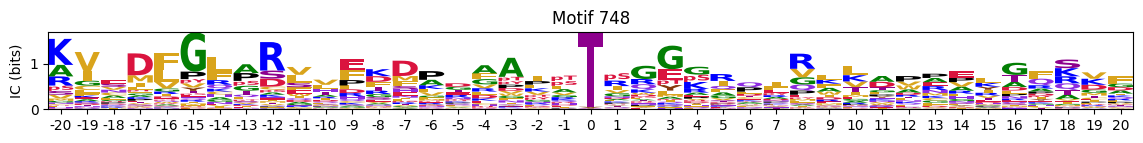

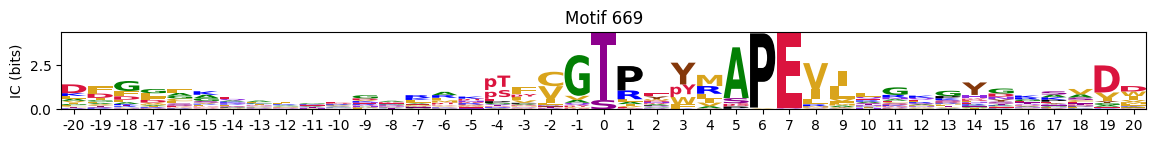

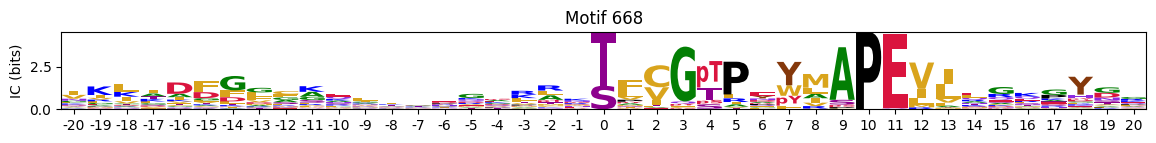

In [ ]:
plot_logos(pssms2,748,669,668)

### Most common

In [ ]:
idxs = all_site_onehot.sum().sort_values(ascending=False).head(20).index

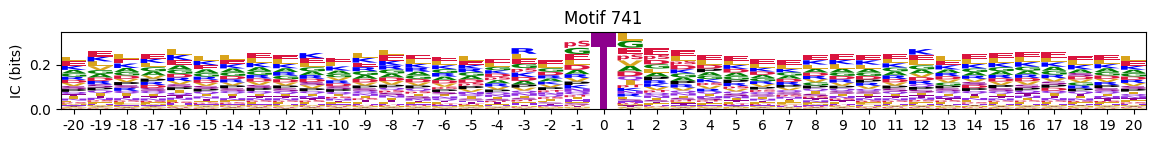

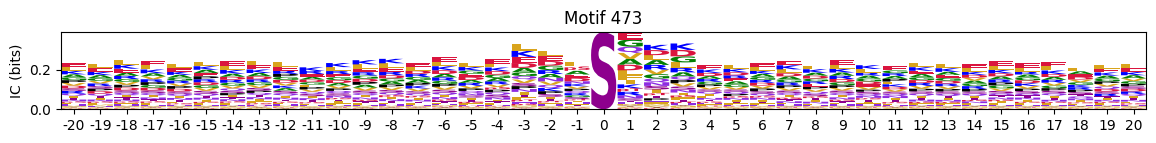

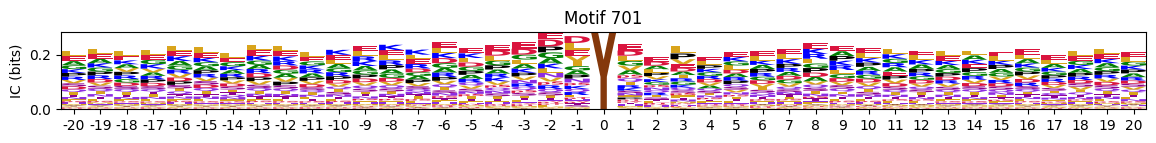

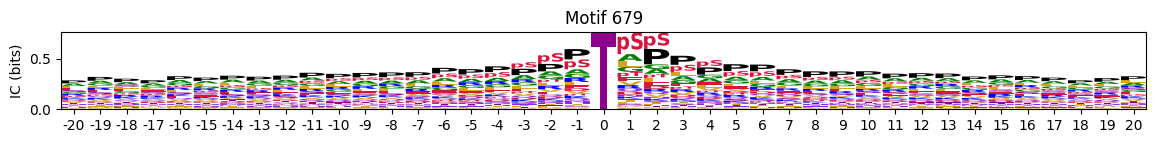

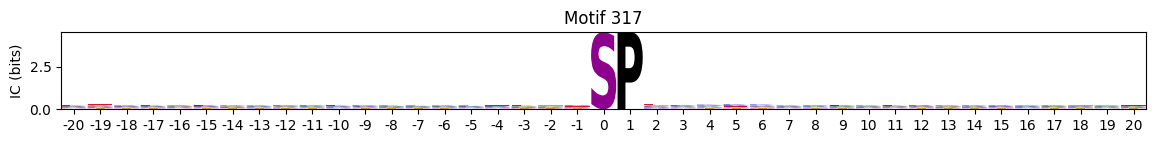

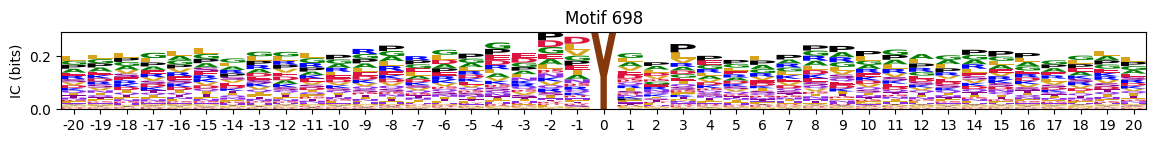

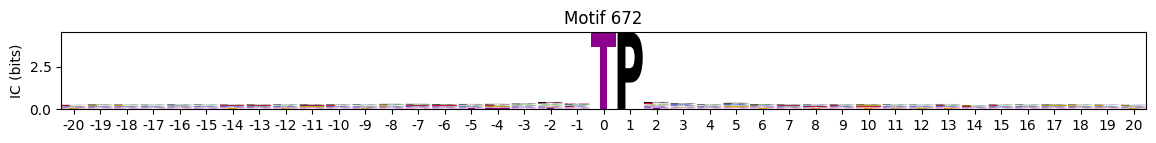

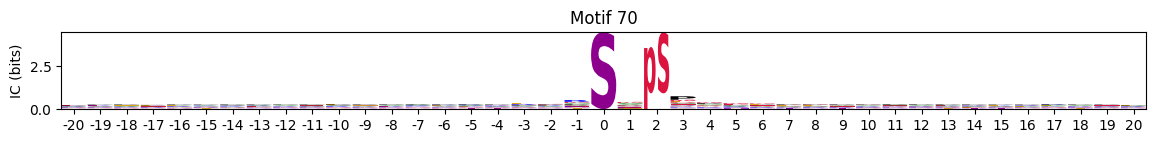

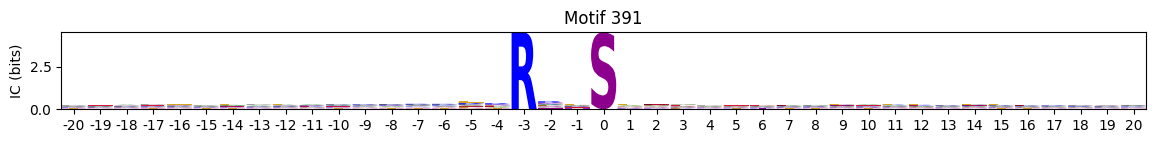

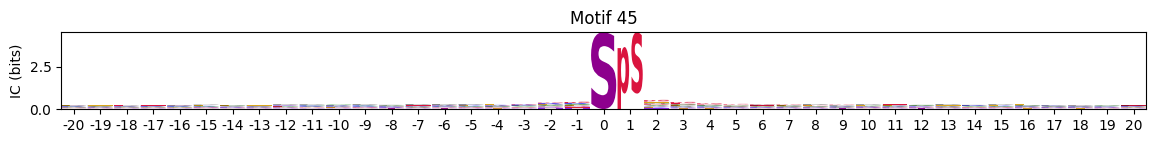

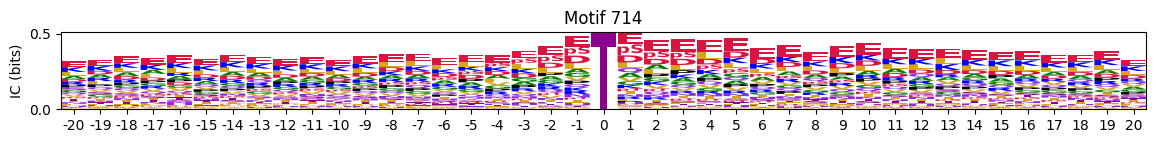

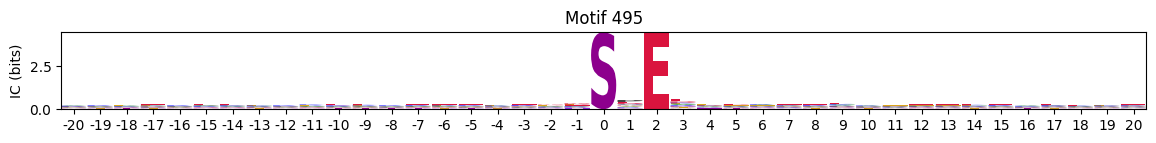

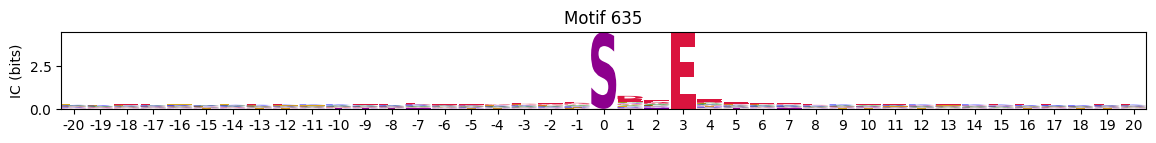

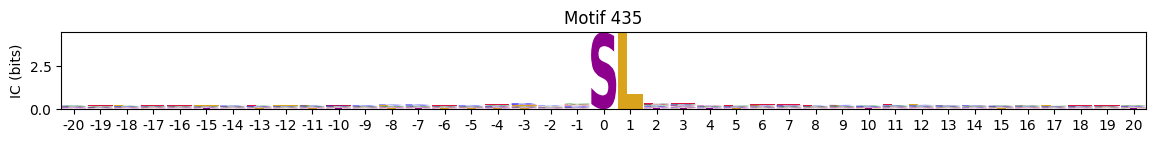

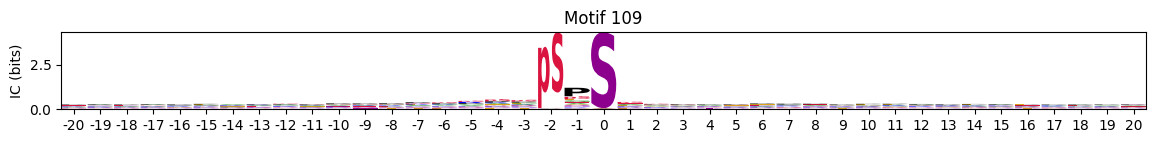

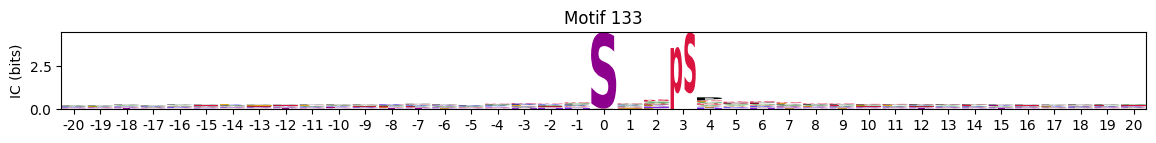

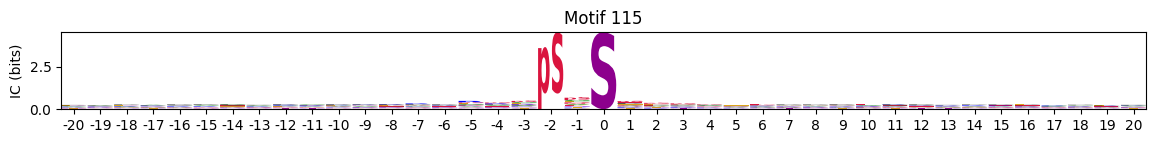

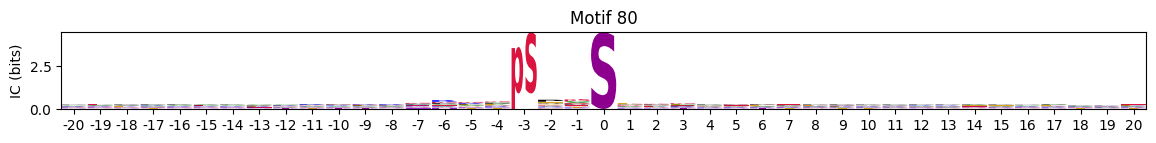

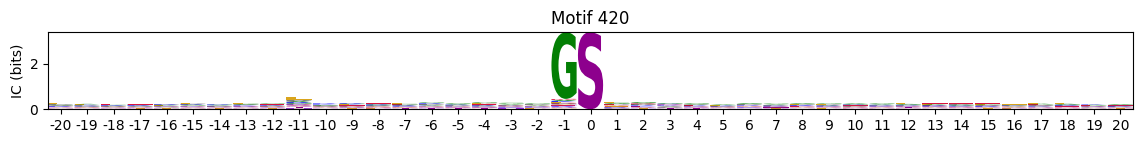

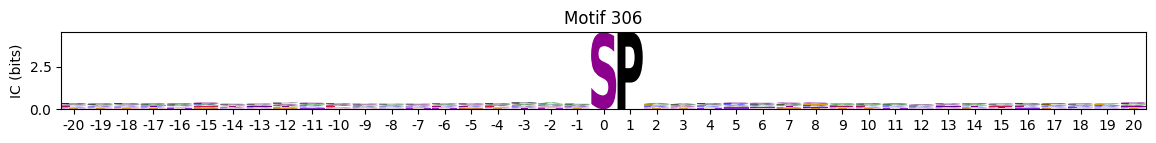

In [ ]:
plot_logos(pssms2, *idxs)

### Entropy per position

In [ ]:
pssms2_entropy = pssms2.apply(lambda r: entropy_flat(r),axis=1)

In [ ]:
# remove 0 and focus on those neighboring residues
pssms2_entropy = pssms2_entropy.drop(columns=0)

In [ ]:
idxs=pssms2_entropy.min(1).sort_values().head(10).index

Motif with lowest entropies:

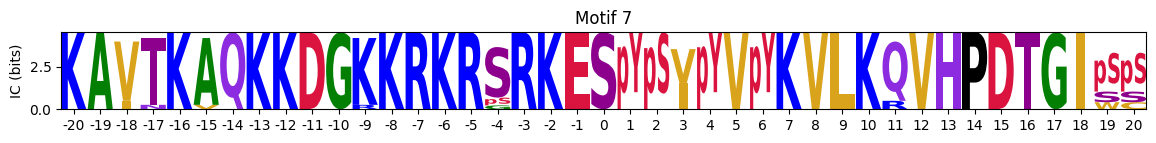

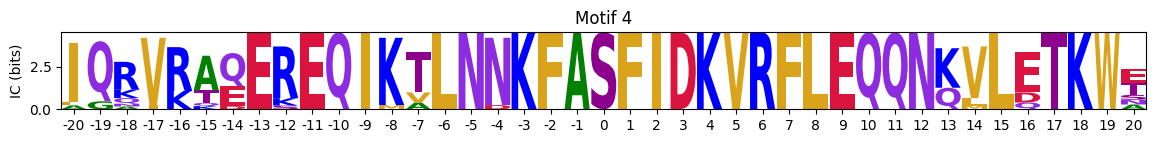

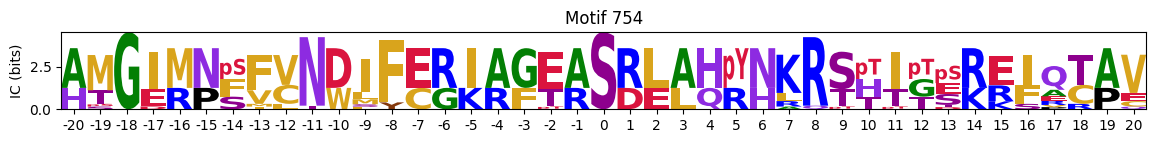

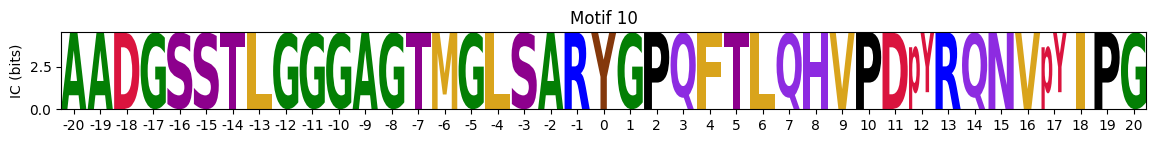

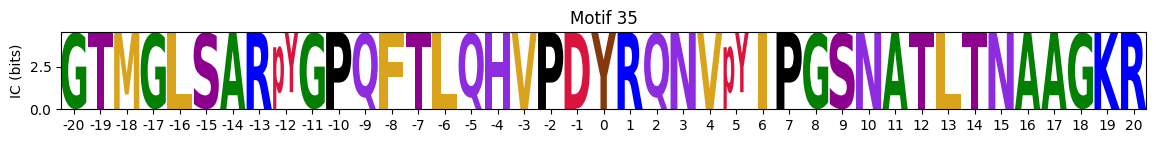

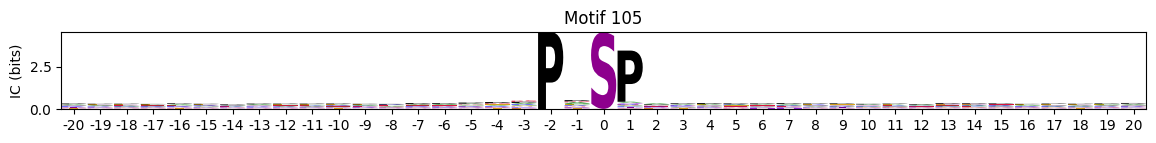

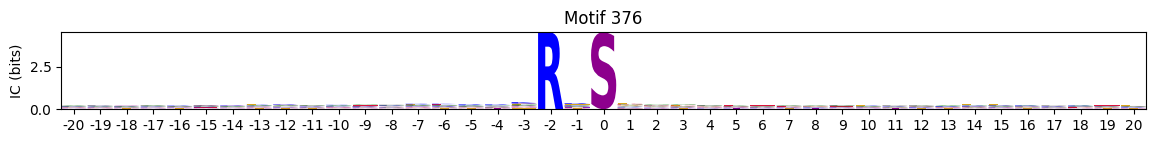

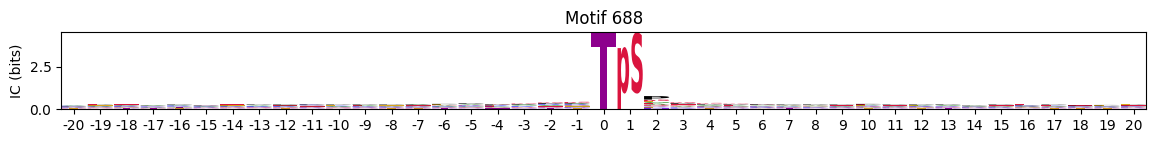

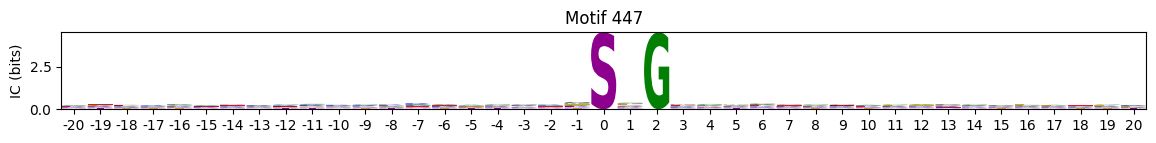

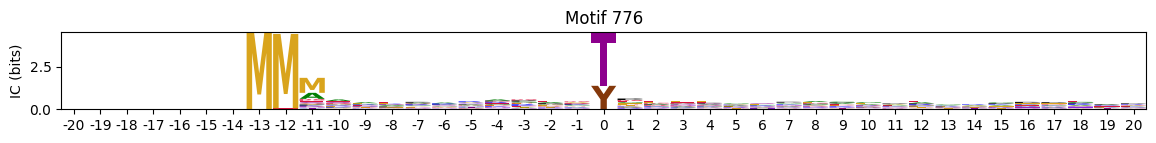

In [ ]:
plot_logos(pssms2,*idxs)

### Low sum entropy (similar to median, but remove terminal )

Motifs with low median entropies:

In [ ]:
idxs=pssms2_entropy.sum(1).sort_values().head(80).index

The first one is mostly Zinc finger protein

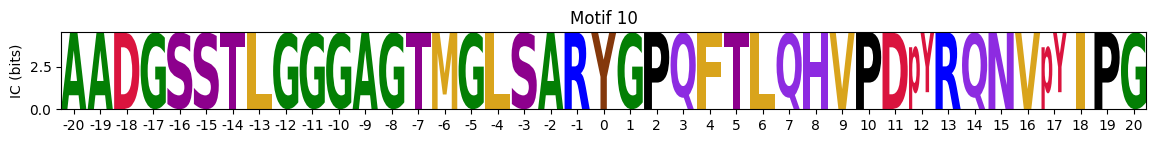

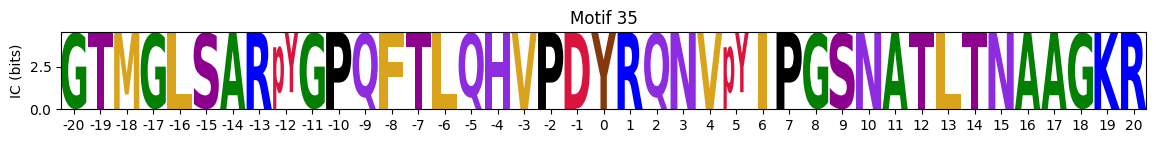

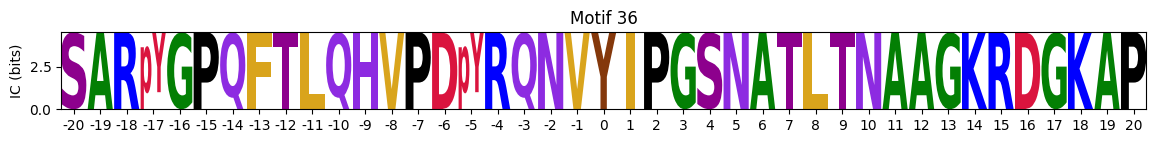

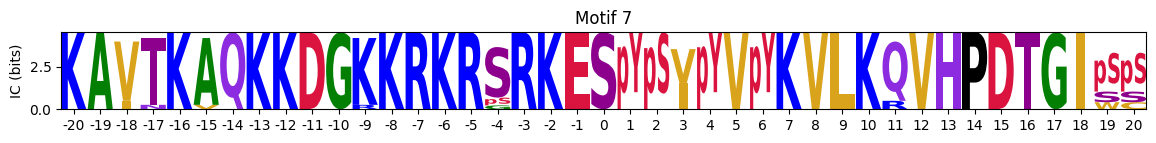

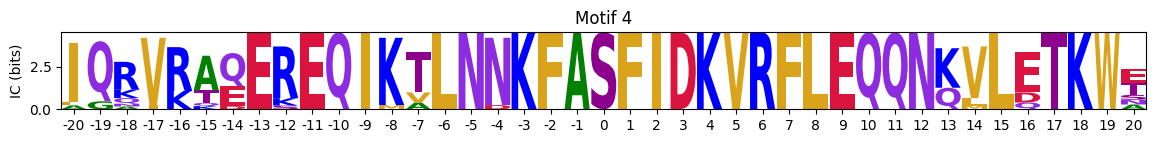

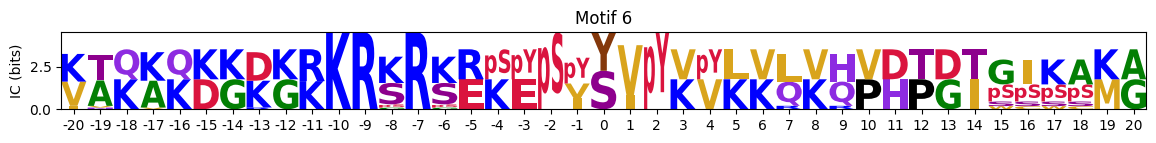

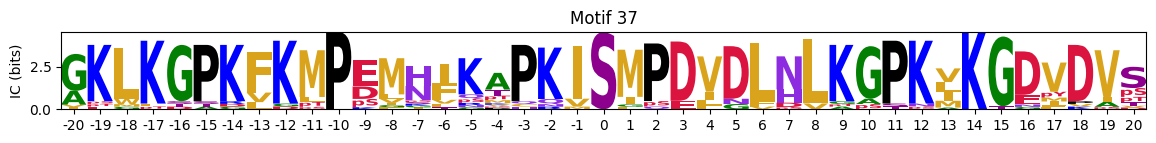

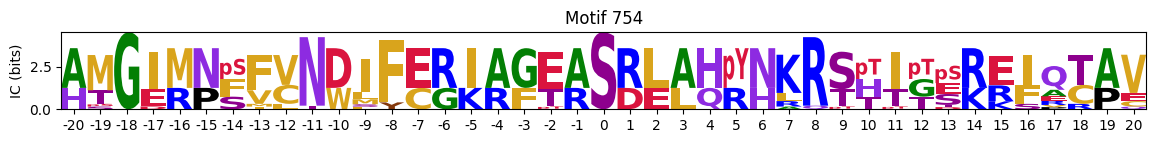

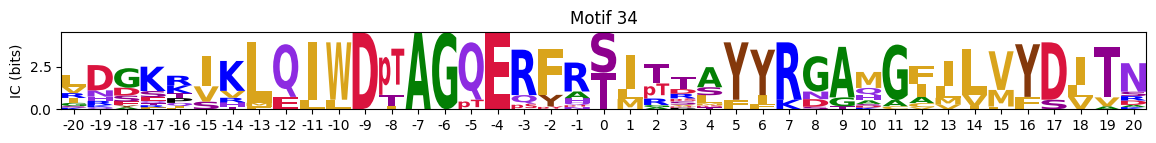

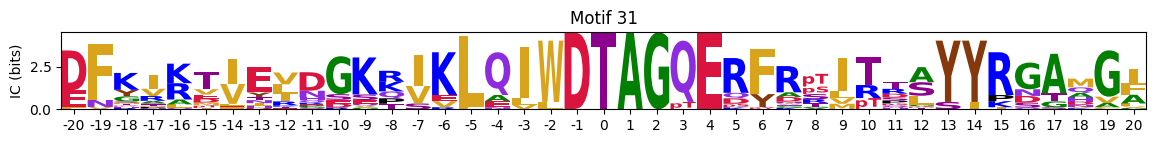

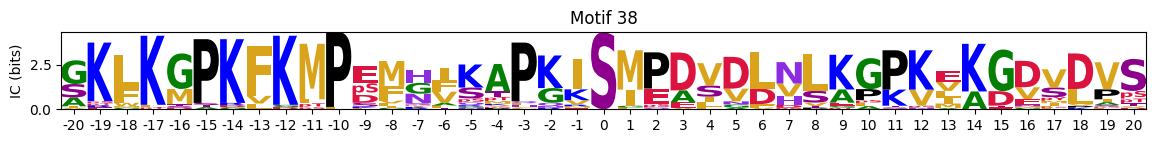

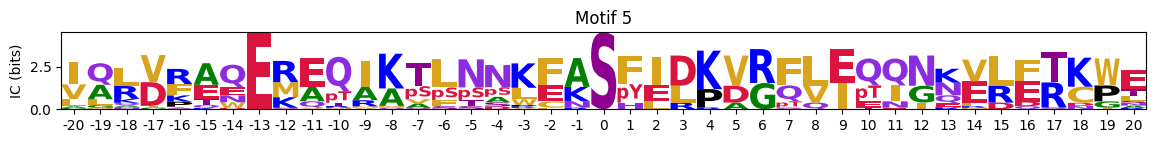

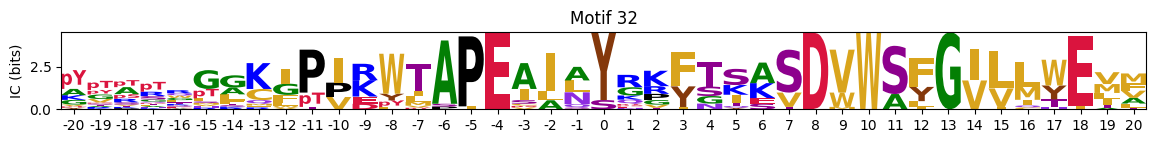

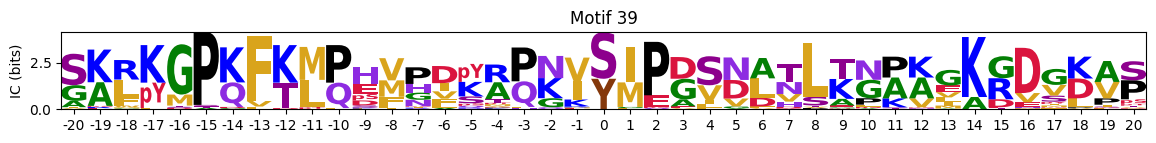

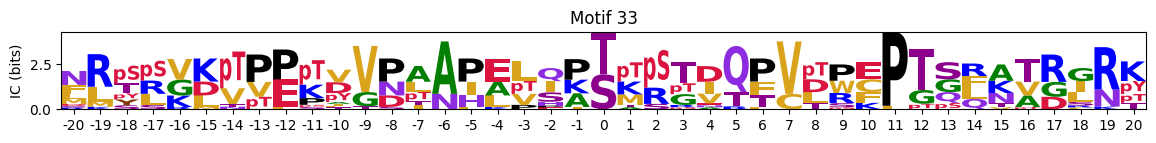

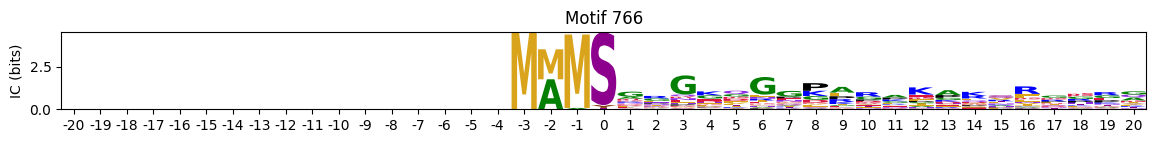

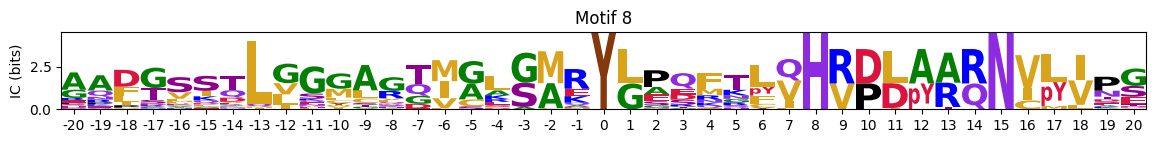

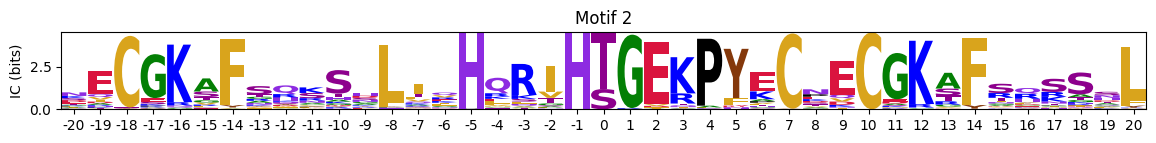

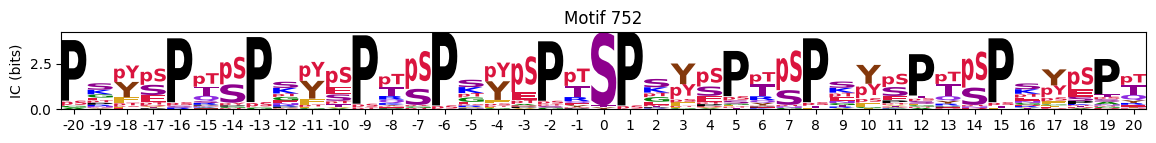

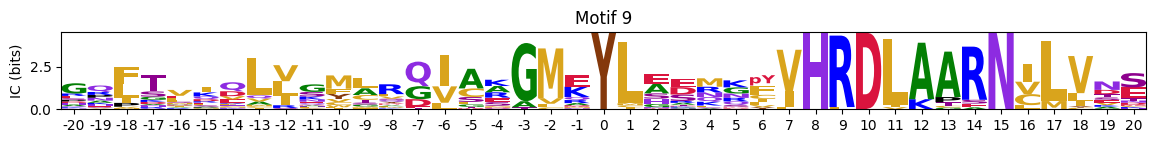

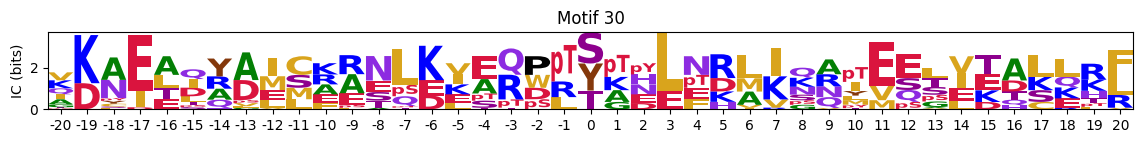

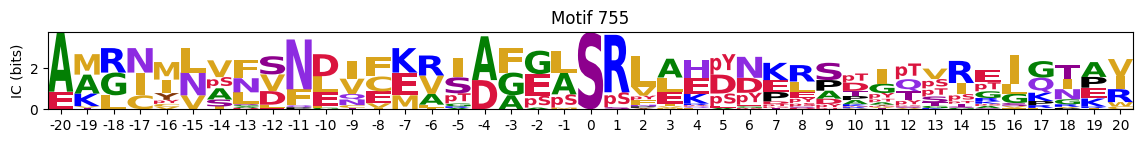

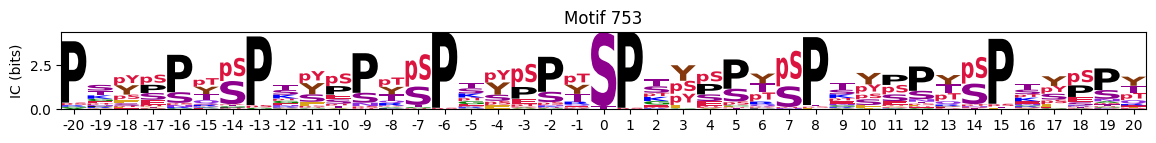

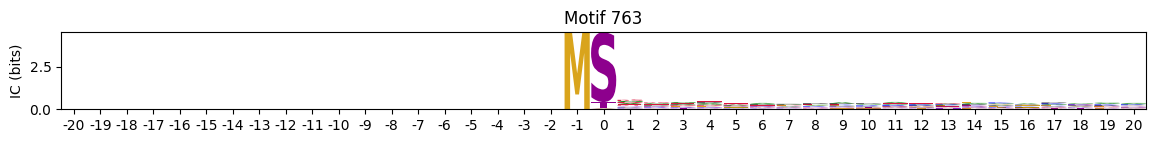

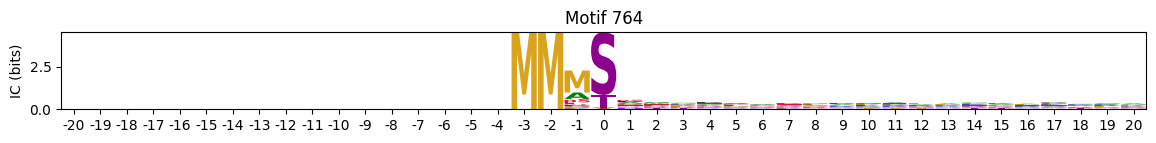

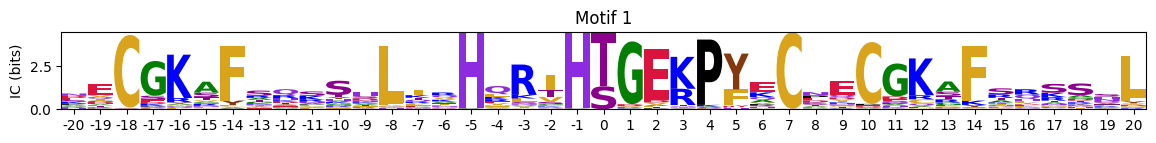

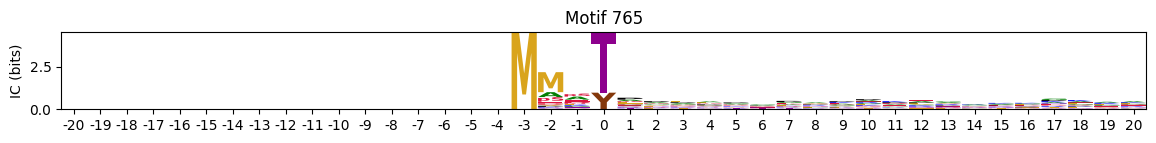

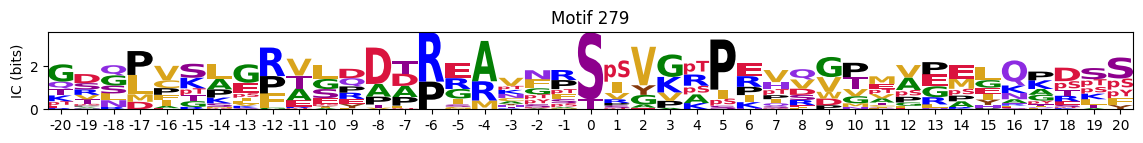

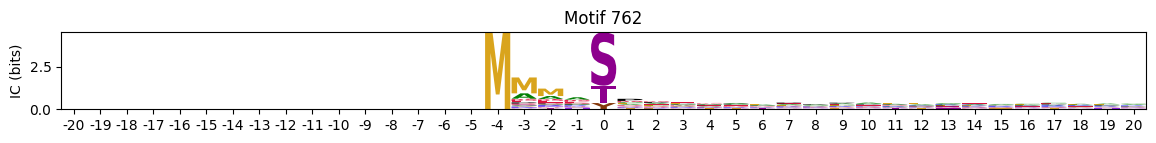

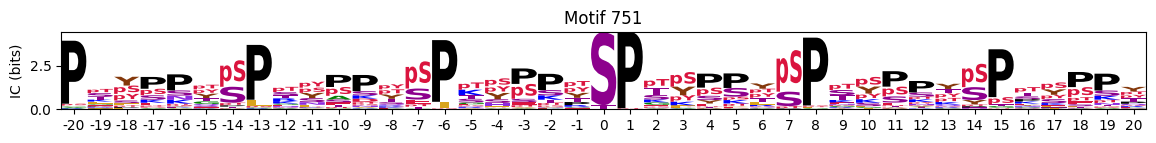

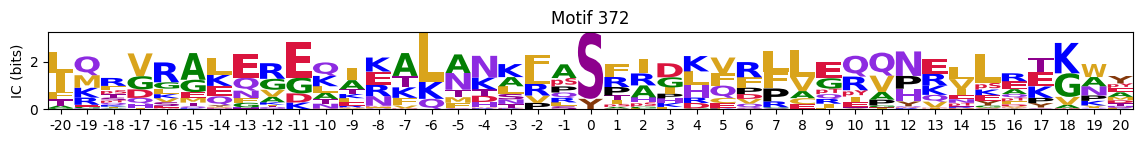

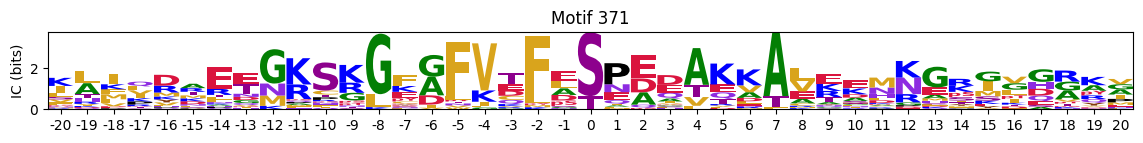

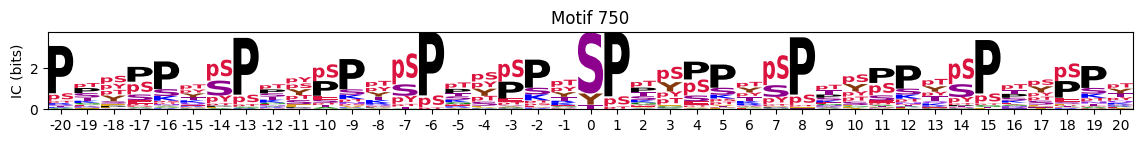

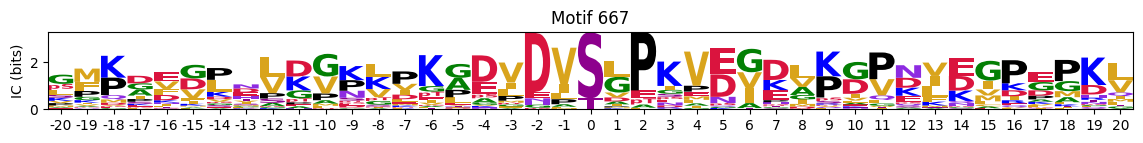

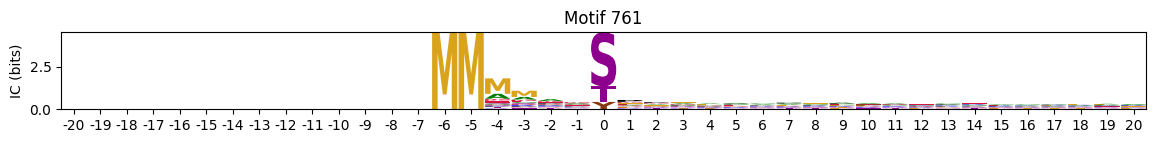

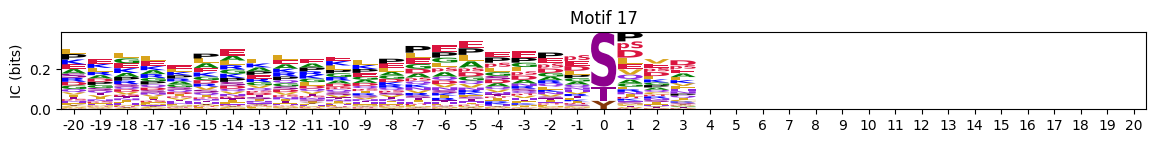

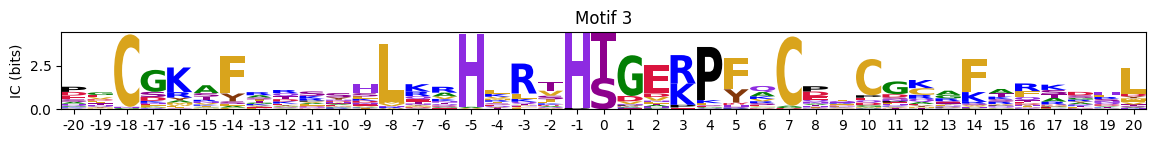

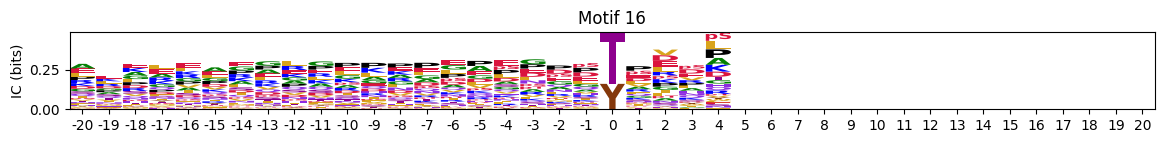

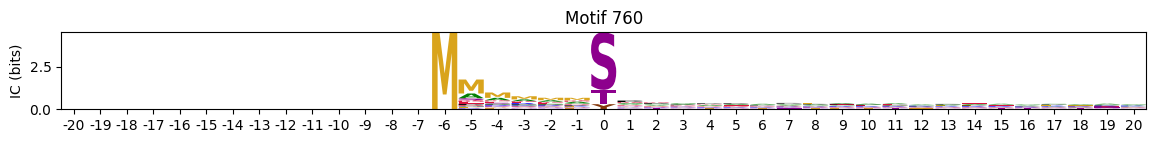

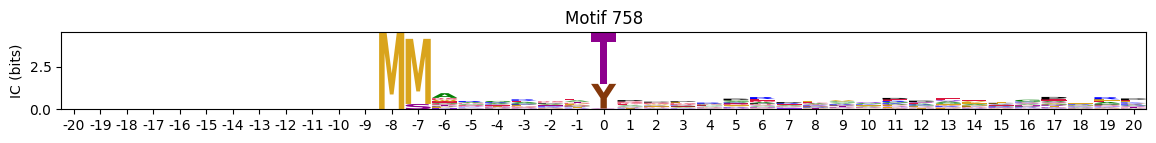

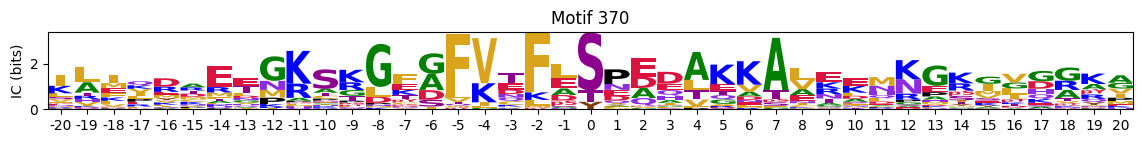

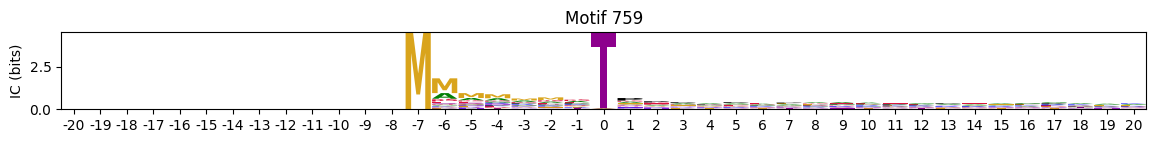

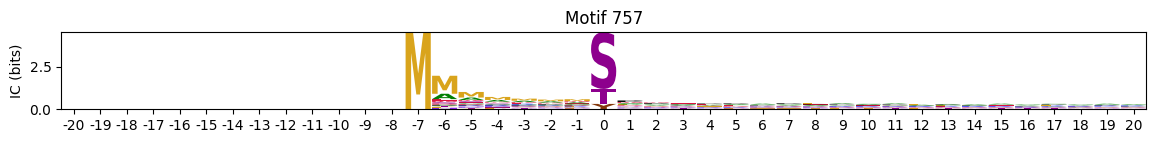

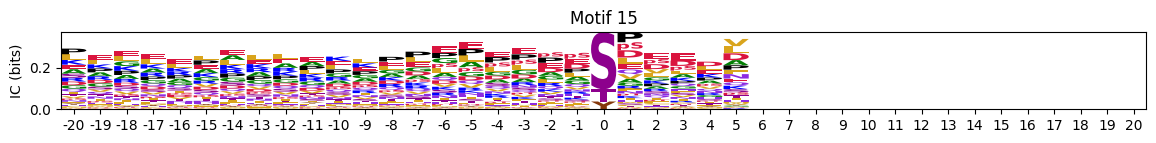

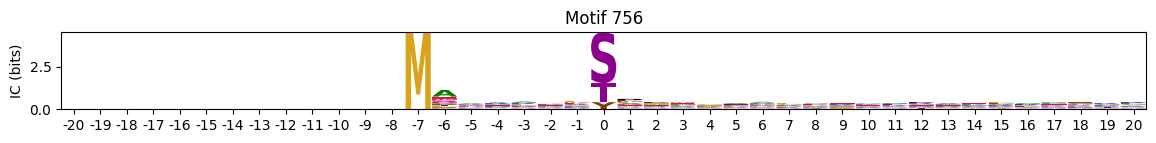

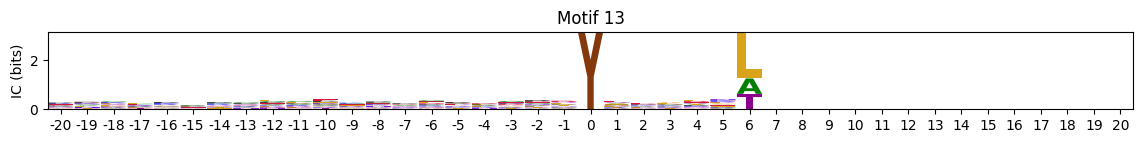

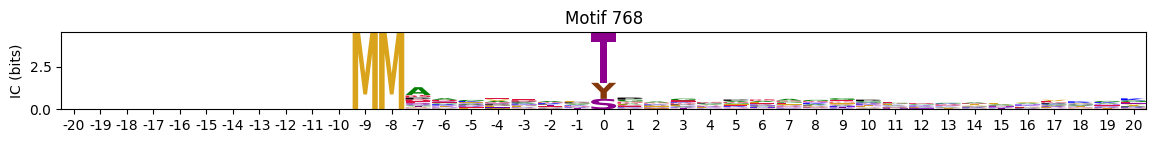

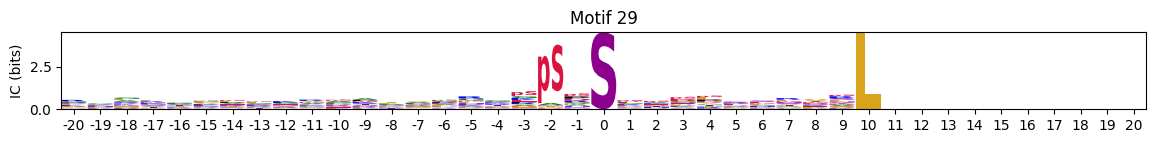

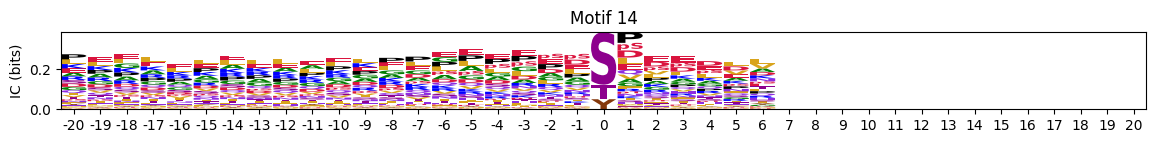

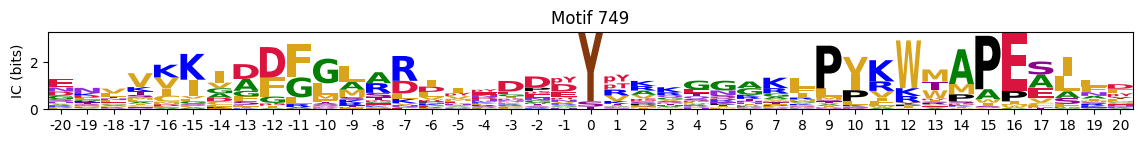

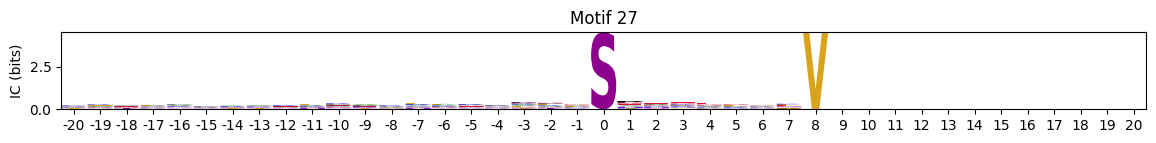

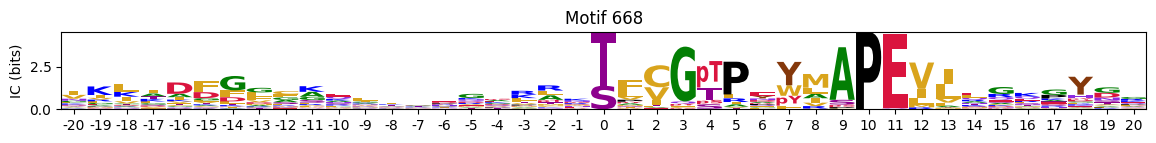

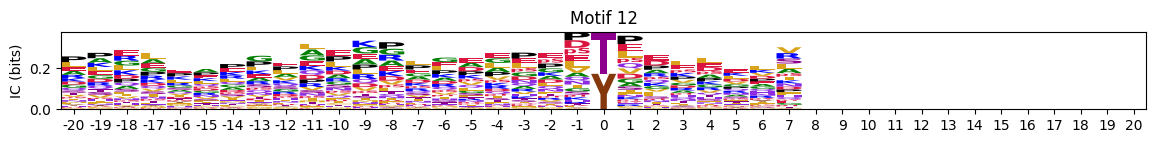

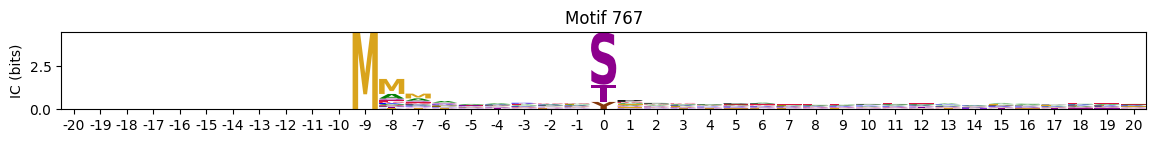

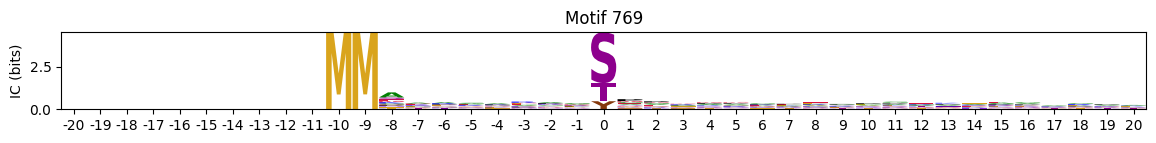

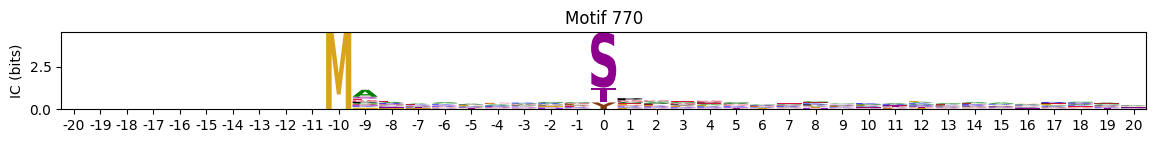

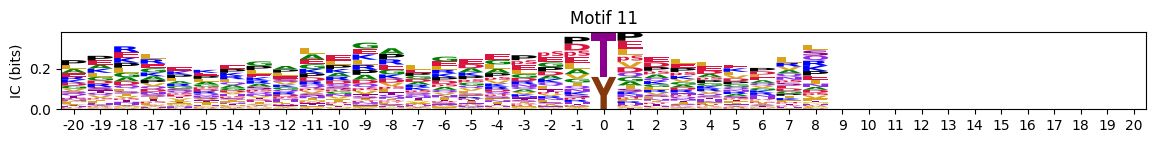

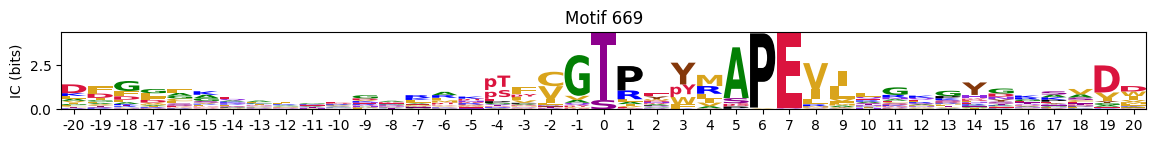

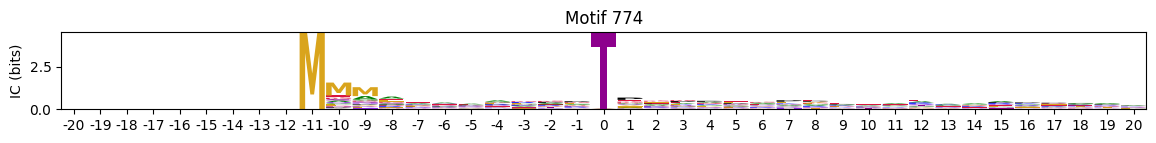

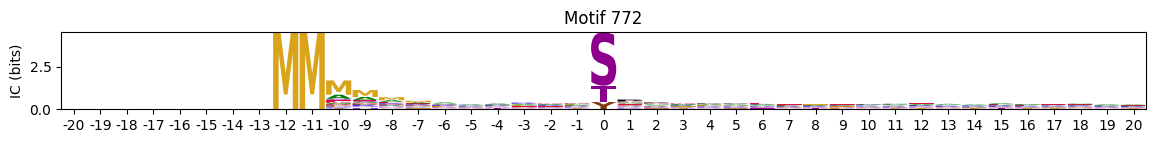

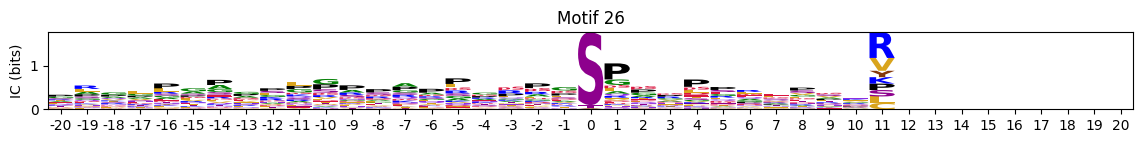

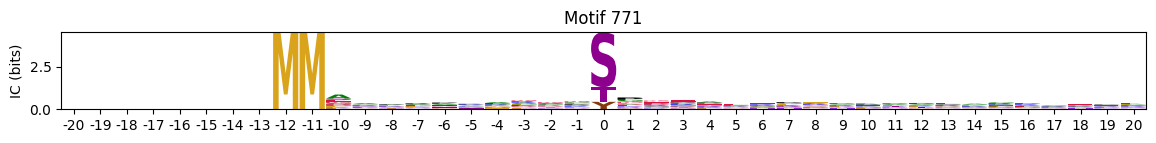

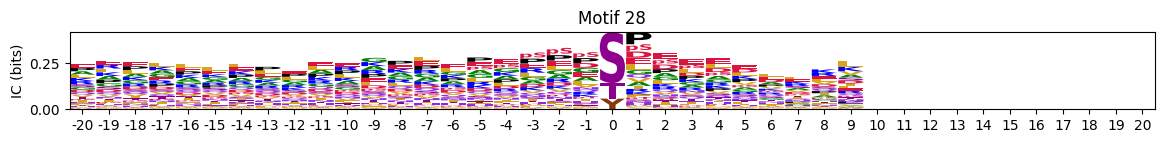

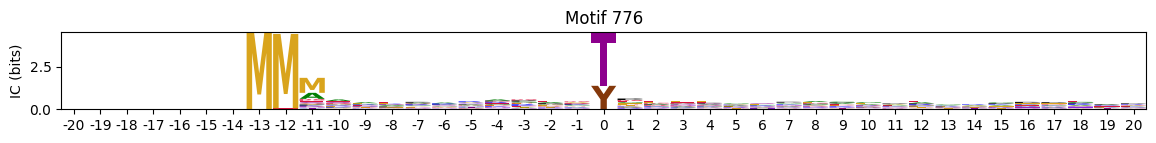

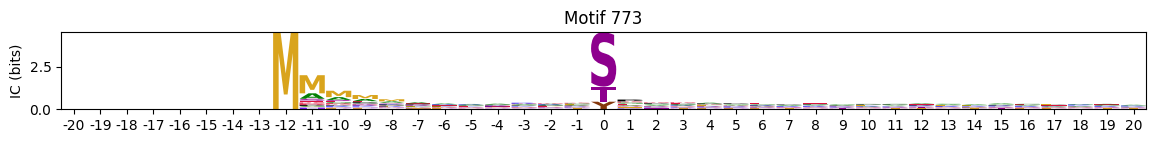

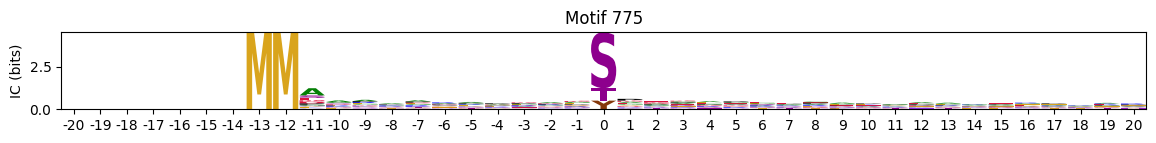

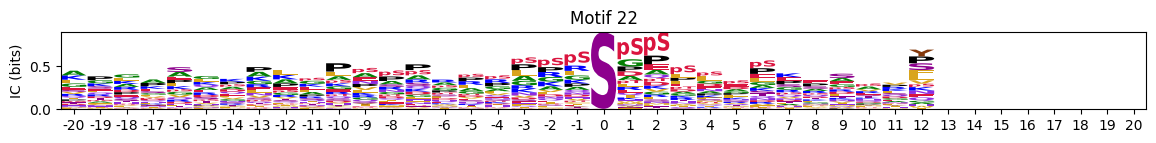

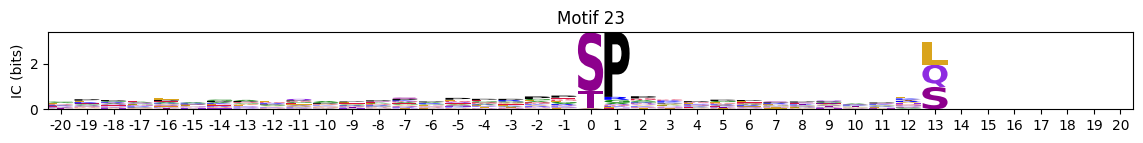

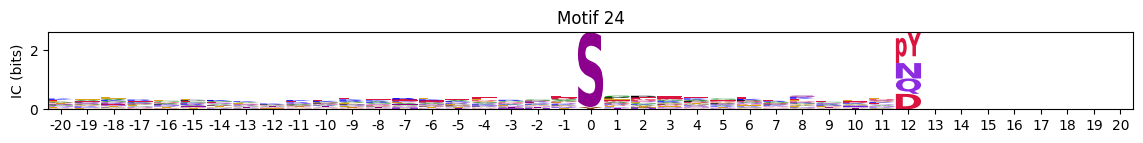

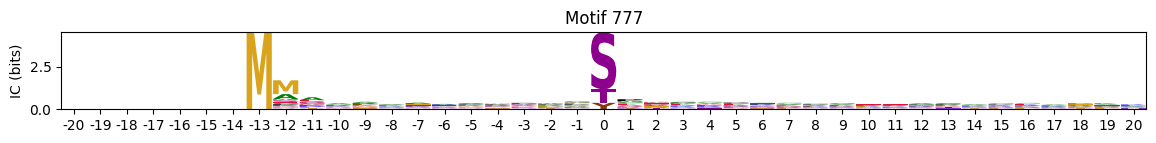

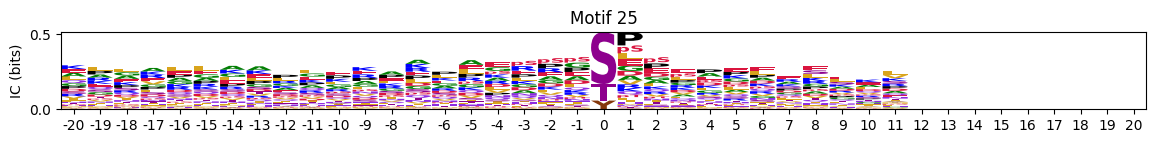

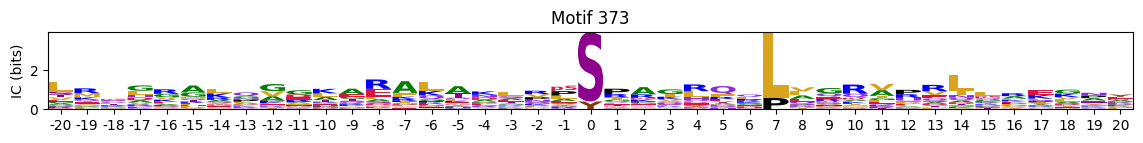

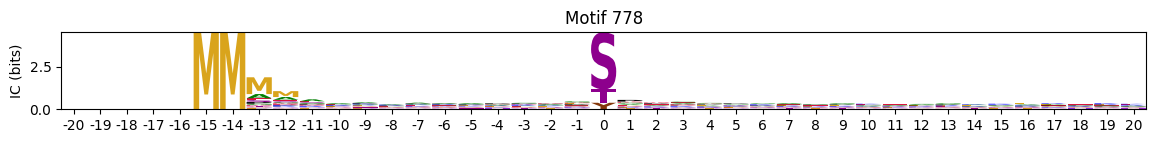

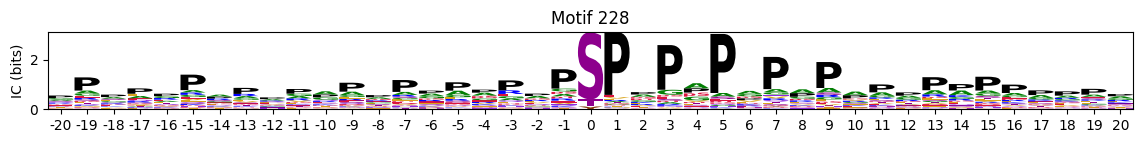

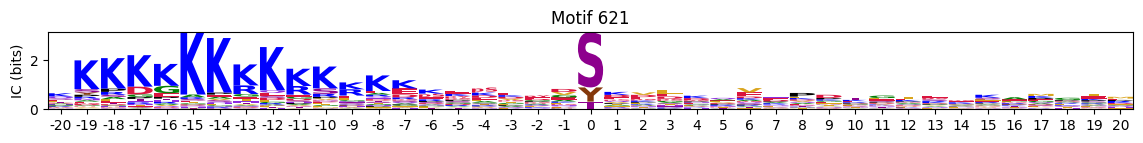

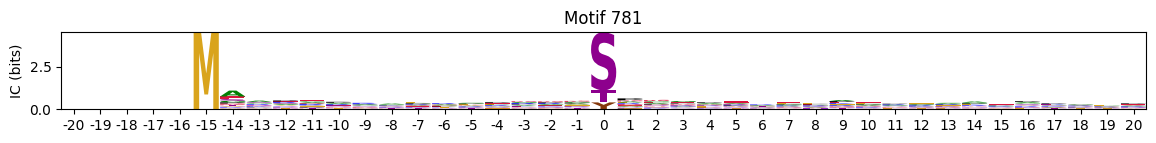

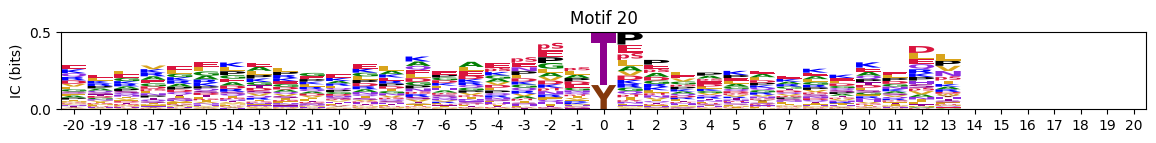

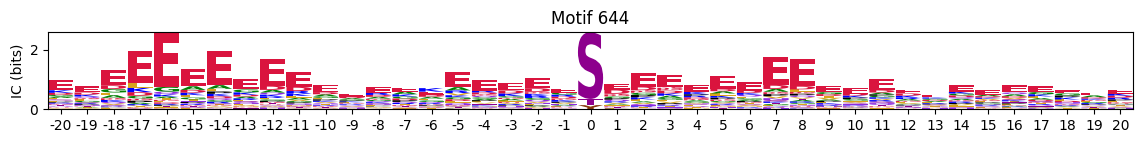

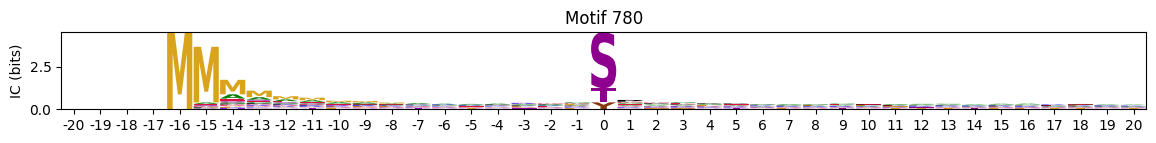

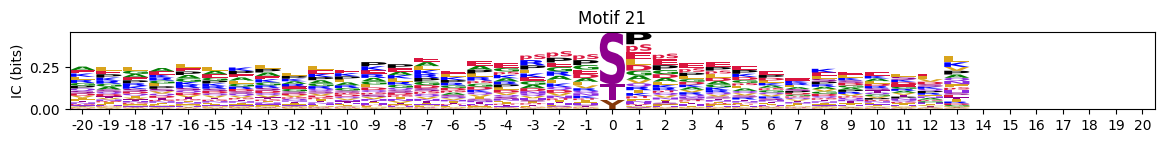

In [ ]:
plot_logos(pssms2,*idxs)

In [ ]:
idxs=pssms2_entropy.sum(1).sort_values().head(10).index

In [ ]:
idxs=(pssms2==0).sum(1).sort_values(ascending=False).index

### C-terminal motifs

In [ ]:
zeros_right = pssms2.apply(lambda r: (recover_pssm(r).loc[:,1:].sum()==0).sum() , axis=1)

In [ ]:
idxs = zeros_right.sort_values(ascending=False).head(10).index

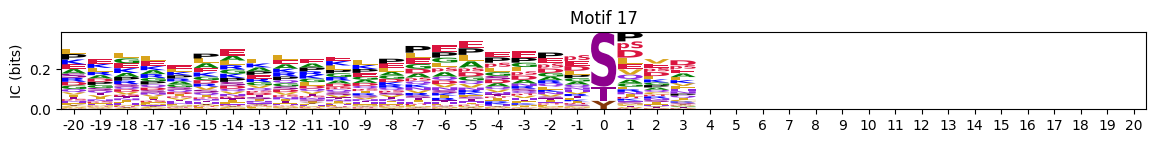

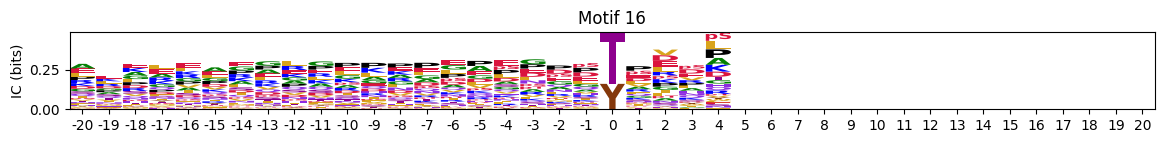

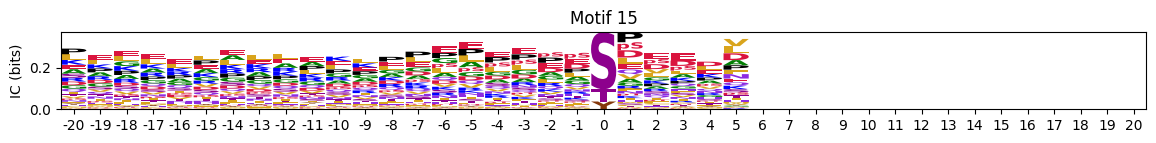

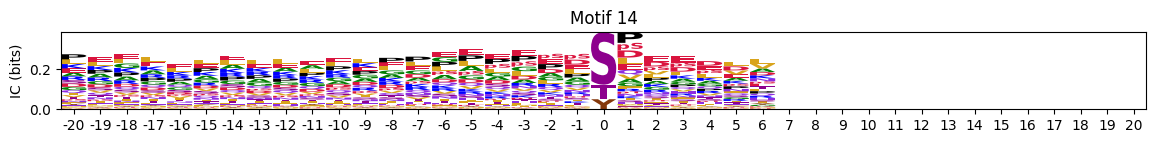

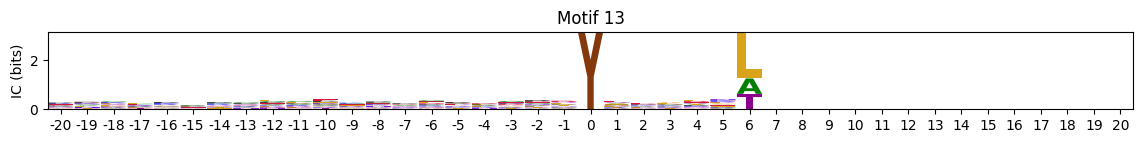

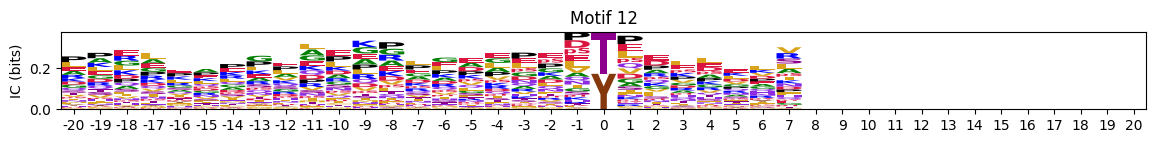

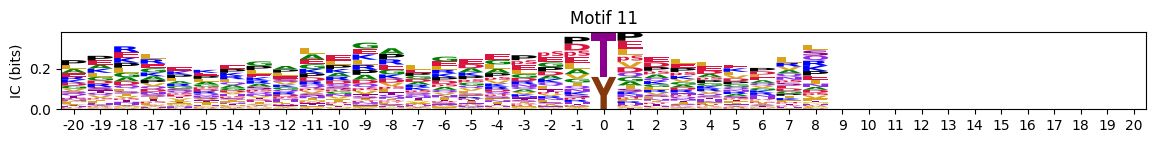

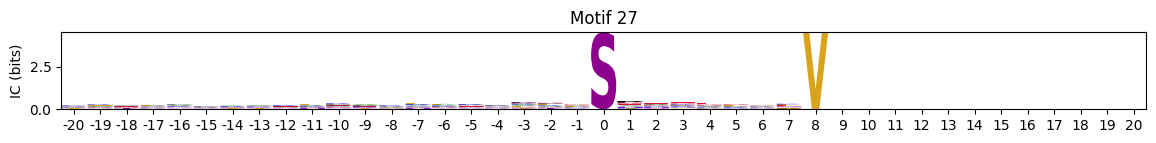

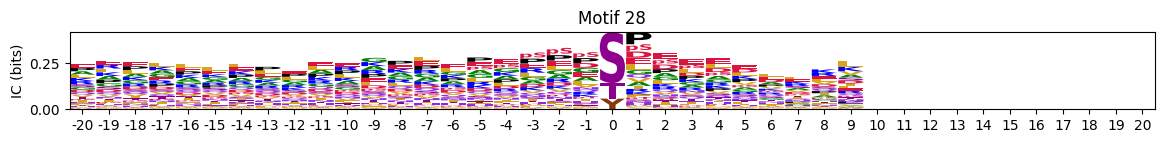

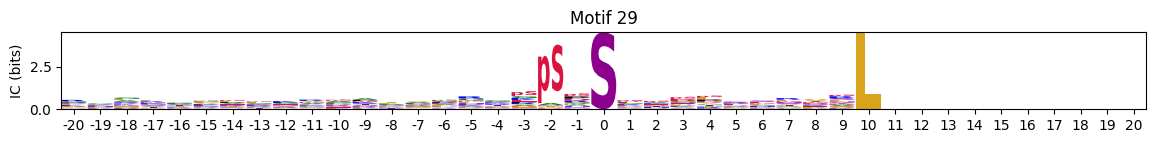

In [ ]:
plot_logos(pssms2,*idxs)

N-Terminal motifs:

In [ ]:
zeros_left = pssms2.apply(lambda r: (recover_pssm(r).loc[:,:0].sum()==0).sum() , axis=1)

In [ ]:
idxs = zeros_left.sort_values(ascending=False).head(10).index

In [ ]:
# zeros = pssms2.apply(lambda r: (recover_pssm(r).sum()==0).sum() , axis=1)

# idxs = zeros.sort_values(ascending=False).head(10).index

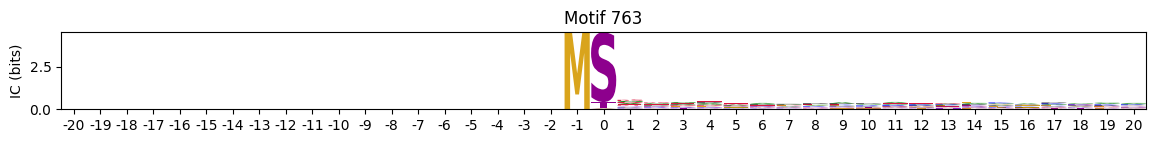

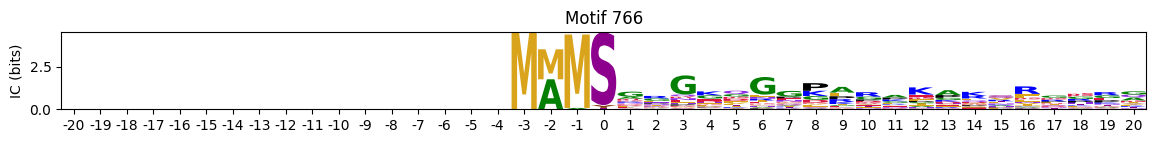

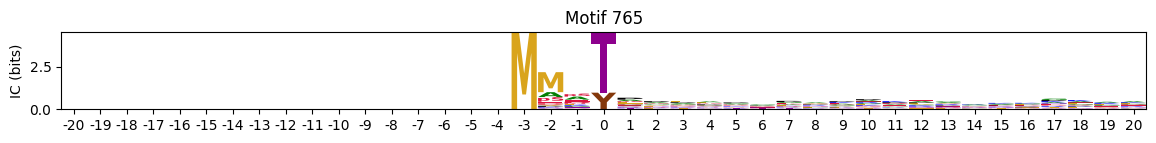

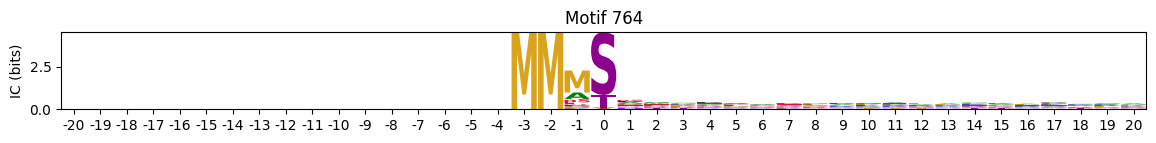

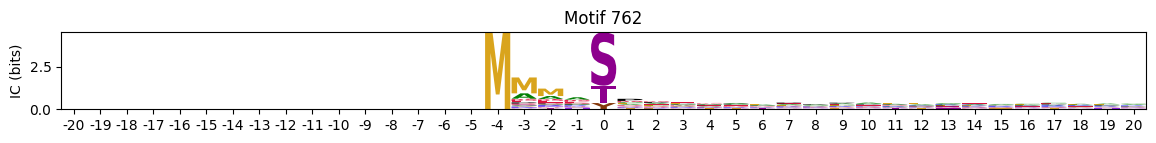

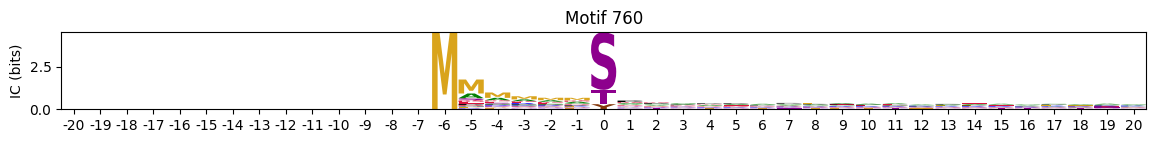

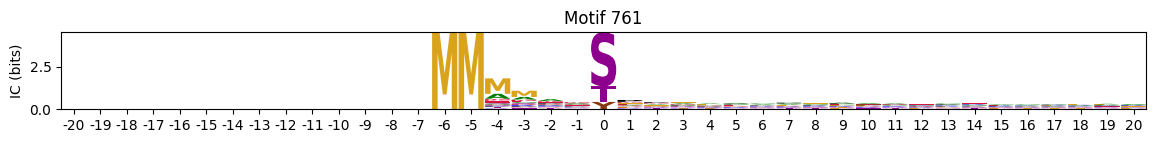

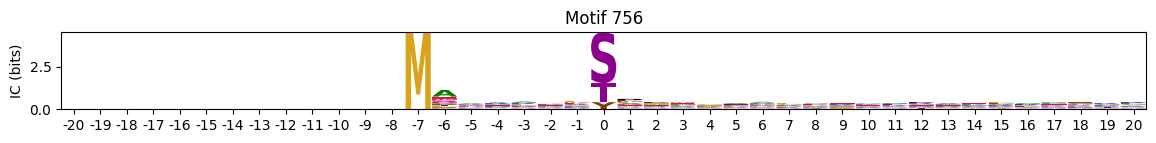

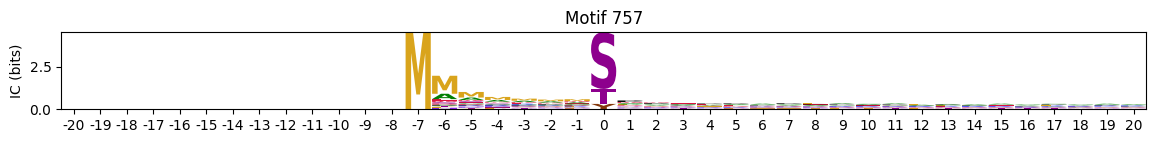

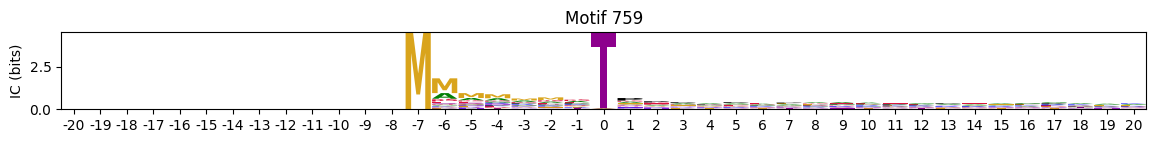

In [ ]:
plot_logos(pssms2,*idxs)